In [1]:
# Import necessary libraries and set random seeds for reproducibility
import torch
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(6)

# Device configuration
if torch.cuda.is_available():
    torch.cuda.manual_seed(6)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

import random
random.seed(6)

import numpy as np
np.random.seed(6)
import matplotlib.pyplot as plt

In [2]:
# Set up the MNIST dataset
batch_size = 128
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True)

# Load the dataset into memory
X = trainset.data.to(device)/ 255.0  # Normalize pixel values to [0, 1]
trainset = torch.utils.data.TensorDataset(X)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

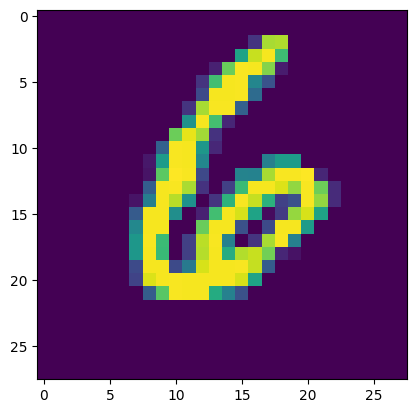

In [3]:
# function to display an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg)
    plt.show()


# get some random training images
image = trainset[13][0]

# show images
imshow(image)

In [4]:
# Variational Autoencoder (VAE) model definition
class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Define the encoder: sigle hidden layer with 500 units, outputting 50 Gaussian latent variables
        # The output is split into mean and log variance of each latent variable
        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, 500),
            torch.nn.Softplus(),
            torch.nn.Linear(500, 100),
            torch.nn.Unflatten(1, (2, 50))
        ).to(device)
    
        # Define the decoder: single hidden layer with 500 units
        # It reconstructs the image from a sampling of the latent variables
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(50, 500),
            torch.nn.Softplus(),
            torch.nn.Linear(500, 28*28),
            torch.nn.Sigmoid(),
            torch.nn.Unflatten(1, (28, 28))
        ).to(device)
    
    # Reparameterization trick to sample from the latent space
    def reparametrize(self, mean, logvar):
        eps = torch.randn_like(logvar).to(device)
        return mean + eps * torch.exp(logvar / 2)
    
    def forward(self, x):
        latent = self.encoder(x)
        mean, logvar = latent[...,0,:], latent[...,1,:]
        z = self.reparametrize(mean, logvar)
        return self.decoder(z), mean, logvar

In [5]:
# The loss function for the VAE is a combination of reconstruction loss and Kullback-Leibler divergence
bce_loss = torch.nn.BCELoss(reduction='sum').to(device)
def vae_loss(x, x_hat, mean, log_var):
    reconstruction_loss = bce_loss(x_hat, x)
    # Kullback-Leibler Divergence between the learned distribution and the standard normal distribution
    # It forces the latent space to follow a Gaussian distribution
    KLD = 0.5 * torch.sum(mean.pow(2) + log_var.exp() - 1 - log_var)
    return reconstruction_loss + KLD

In [6]:
# Training loop with different Adam optimizer configurations
from my_adam import My_adam, My_adam_no_bias_correction
from itertools import product

epochs = 10
beta1_choices = [0.0, 0.5, 0.9]
beta2_choices = [0.0, 0.5, 0.99, 0.999, 0.9999]
log10_alpha_choices = [-4.5, -4.0, -3.5, -3.0, -2.5, -2.0]
optimizers = [My_adam, My_adam_no_bias_correction]
losses = []

for beta1, beta2, get_opt in product(beta1_choices, beta2_choices, optimizers):
    loss_log = torch.zeros(len(log10_alpha_choices)).to(device)
    for i, log10_alpha in enumerate(log10_alpha_choices):
        net = VAE().to(device)
        alpha = 10 ** log10_alpha
        opt = get_opt(net.parameters(), lr=alpha, betas=(beta1, beta2), eps=1e-8)
        print(f"Training with beta1={beta1}, beta2={beta2}, alpha={alpha}")
        for epoch in range(epochs):
            for x in trainloader:
                x = x[0]
                opt.zero_grad()
                x_hat, mean, log_var = net(x)
                loss = vae_loss(x, x_hat, mean, log_var)
                loss.backward()
                opt.step()
        loss_log[i] = loss/batch_size
    losses.append(loss_log)
    

Training with beta1=0.0, beta2=0.0, alpha=3.1622776601683795e-05
Training with beta1=0.0, beta2=0.0, alpha=0.0001
Training with beta1=0.0, beta2=0.0, alpha=0.00031622776601683794
Training with beta1=0.0, beta2=0.0, alpha=0.001
Training with beta1=0.0, beta2=0.0, alpha=0.0031622776601683794
Training with beta1=0.0, beta2=0.0, alpha=0.01
Training with beta1=0.0, beta2=0.0, alpha=3.1622776601683795e-05
Training with beta1=0.0, beta2=0.0, alpha=0.0001
Training with beta1=0.0, beta2=0.0, alpha=0.00031622776601683794
Training with beta1=0.0, beta2=0.0, alpha=0.001
Training with beta1=0.0, beta2=0.0, alpha=0.0031622776601683794
Training with beta1=0.0, beta2=0.0, alpha=0.01
Training with beta1=0.0, beta2=0.5, alpha=3.1622776601683795e-05
Training with beta1=0.0, beta2=0.5, alpha=0.0001
Training with beta1=0.0, beta2=0.5, alpha=0.00031622776601683794
Training with beta1=0.0, beta2=0.5, alpha=0.001
Training with beta1=0.0, beta2=0.5, alpha=0.0031622776601683794
Training with beta1=0.0, beta2=0.

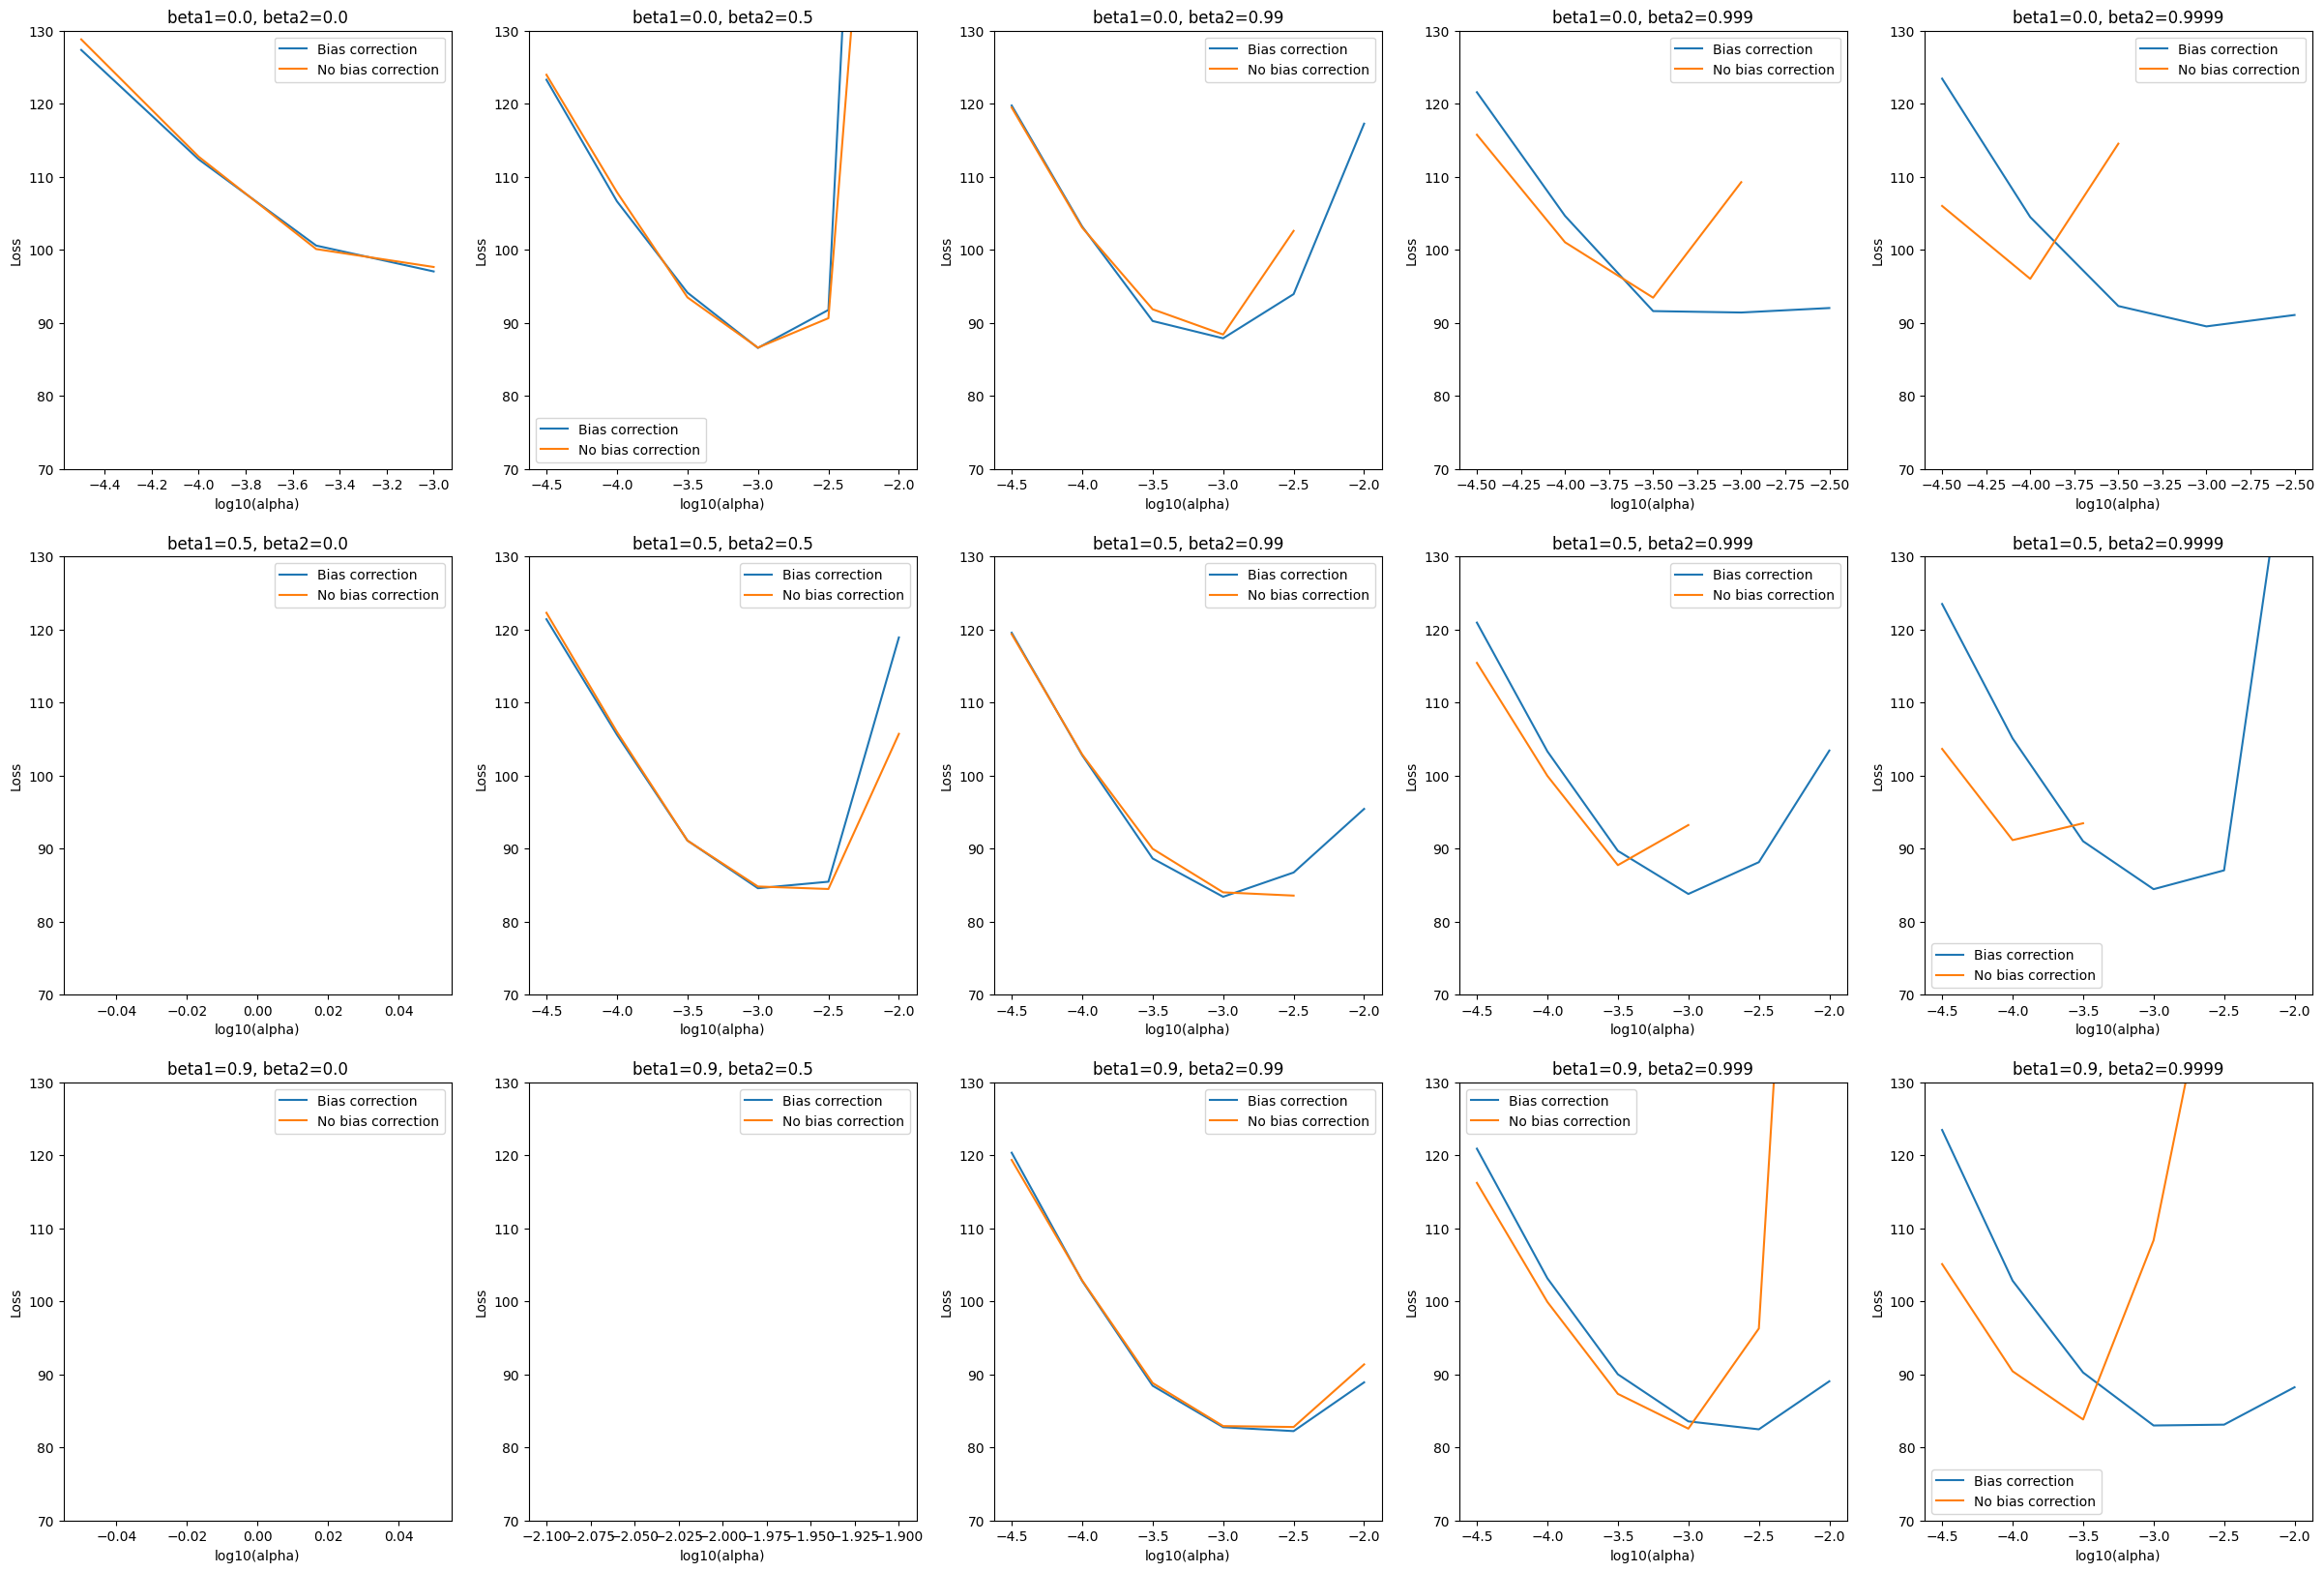

In [8]:
# Plotting the results
plt.figure(figsize=(30, 20))
for i, (beta1, beta2) in enumerate(product(beta1_choices, beta2_choices)):
    plt.subplot(len(beta1_choices), len(beta2_choices), i + 1)
    plt.plot(log10_alpha_choices,losses[2*i].cpu().detach(), label="Bias correction")
    plt.plot(log10_alpha_choices, losses[2*i + 1].cpu().detach(), label="No bias correction")
    plt.legend()
    plt.ylim(70, 130)
    plt.title(f"beta1={beta1}, beta2={beta2}")
    plt.xlabel("log10(alpha)")
    plt.ylabel("Loss")